In [2]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [3]:
import matplotlib.pyplot as plt

In [4]:
import scanpy.external as sce

In [5]:
import torch
import pickle

In [6]:
import anndata

In [7]:
import h5py

In [8]:
import os

In [9]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

#### Load data

In [15]:
adata = sc.read('lung_normal.h5ad')

#### QC

In [29]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True) #qc_vars=['mt', 'ribo']

In [31]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 40000, :]

#### Train model

In [21]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", labels_key='coarse_cell_type_chan')

In [44]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [45]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 24/24: 100%|██████████| 24/24 [16:51<00:00, 42.14s/it, loss=3.71e+03, v_num=1]


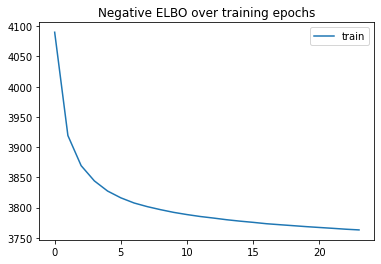

In [46]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [47]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [48]:
lvae.train(25)

INFO     Training for 25 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [37:12<00:00, 89.30s/it, loss=3.76e+03, v_num=1]


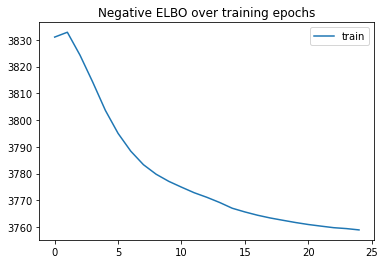

In [49]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [50]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [51]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [12]:
lvae.save('lung_normal_tissue_all_cells_scanvi', overwrite=True)

In [57]:
adata.obs["C_scANVI"] = lvae.predict(adata)

In [58]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

### Lymphoid only

In [20]:
adata_lymphoid = adata[adata.obs['C_scANVI'] == 'Lymphoid'].copy()

In [23]:
adata_lymphoid.write(os.path.join(data_dir, 'lymphoid_cells_lung_normal_tissue.h5ad'))

In [24]:
adata_lymphoid = sc.read(os.path.join(data_dir, 'lymphoid_cells_lung_normal_tissue.h5ad'))

In [96]:
#scvi.model.SCVI.setup_anndata(adata_lymphoid, batch_key="batch", labels_key='celltypist_prediction')
scvi.model.SCVI.setup_anndata(adata_lymphoid, batch_key="batch", labels_key='cell_type_kim')

In [97]:
vae = scvi.model.SCVI(adata_lymphoid, n_layers=2, n_latent=30, gene_likelihood="nb")

In [98]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 55/55: 100%|██████████| 55/55 [17:19<00:00, 18.90s/it, loss=2.68e+03, v_num=1]


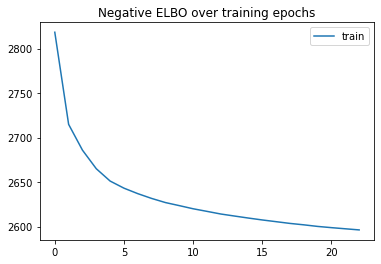

In [204]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [99]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_lymphoid,
    unlabeled_category="Unknown",
)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [100]:
lvae.train(25)

INFO     Training for 25 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [16:10<00:00, 38.83s/it, loss=2.68e+03, v_num=1]


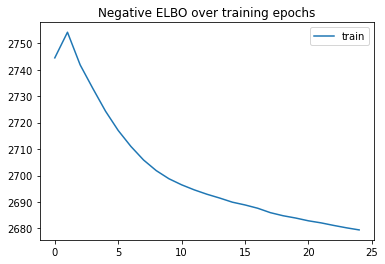

In [101]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [102]:
adata_lymphoid.obsm["X_scVI"] = vae.get_latent_representation(adata_lymphoid)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [103]:
adata_lymphoid.obsm["X_scANVI"] = lvae.get_latent_representation(adata_lymphoid)

In [ ]:
sc.pp.neighbors(adata_lymphoid, use_rep="X_scVI")
sc.tl.umap(adata_lymphoid)

#### scANVI prediction

In [28]:
adata_lymphoid.obs["C_scANVI"] = lvae.predict(adata_lymphoid)

In [29]:
sc.pp.neighbors(adata_lymphoid, use_rep="X_scANVI")
sc.tl.umap(adata_lymphoid)

In [30]:
sc.tl.leiden(adata_lymphoid, resolution=1.5)

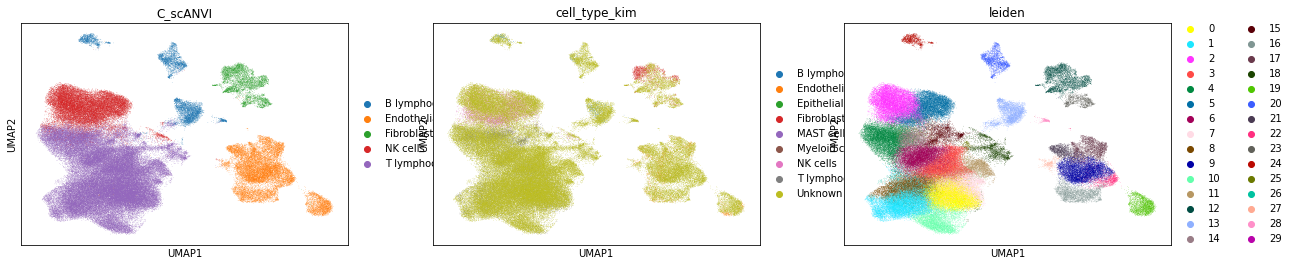

In [31]:
sc.pl.umap(adata_lymphoid, color=['C_scANVI', 'cell_type_kim', 'leiden'])

In [51]:
adata_lymphoid.obs_names_make_unique()

In [52]:
adata_lymphoid.write(os.path.join(data_dir, 'lymphoid_cells_lung_normal_tissue_processed.h5ad'))

In [24]:
adata_lymphoid = sc.read(os.path.join(data_dir, 'lymphoid_cells_lung_normal_tissue_processed.h5ad'))

In [25]:
adata_myeloid = adata[adata.obs['C_scANVI'] == 'Myeloid'].copy()

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [26]:
adata

AnnData object with n_obs × n_vars = 334072 × 14756
    obs: 'tissue', 'batch', 'patient', 'sample', 'dataset', 'classification_cell_type_leader', 'cell_type_kim', 'refined_cell_type_kim', 'sub_cell_type_kim', 'endothelial_cell_type_goeveia', 'coarse_cell_type_chan', 'fine_cell_type_chan', 'general_cell_type_chan', 'med_cell_type_chan', 'pct_counts_mt', 'pct_counts_ribo', 'n_genes_by_counts', 'total_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'neighbors', 'umap', 'coarse_cell_type_chan_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', 'protein_expression'
    obsp: 'connectivities', 'distances'

#### Celltypist predication

In [23]:
import celltypist

In [45]:
adata_immune = adata[adata.obs['C_scANVI'].isin(['Lymphoid', 'Myeloid']).copy()

In [24]:
adata_celltypist = adata_immune.copy()

In [25]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [26]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 149233 cells and 14756 genes
🔗 Matching reference genes in the model
🧬 4003 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [27]:
adata_immune.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_immune.obs.index]
adata_immune.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_immune.obs.index]

In [55]:
adata_celltypist = adata_lymphoid.copy()

In [56]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [57]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

In [58]:
adata_lymphoid.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_lymphoid.obs.index]#.to_numpy()
adata_lymphoid.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_lymphoid.obs.index]#.to_numpy()

In [134]:
pro_adata_lymphoid = sc.AnnData(adata_lymphoid.obsm["protein_expression"].copy(), obs=adata_lymphoid.obs)
pro_adata_lymphoid_non_zero = pro_adata_lymphoid[np.sum(pro_adata_lymphoid.to_df(), axis=1) != 0].copy()
sc.pp.log1p(pro_adata_lymphoid_non_zero)

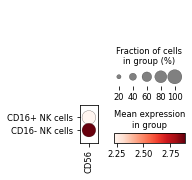

In [144]:
sc.pl.dotplot(pro_adata_lymphoid_non_zero[[x == 'NK' for x in pro_adata_lymphoid_non_zero.obs['nk_cells']]] , ['CD56'], groupby='celltypist_majority_voting', save='CD56_ADT_CD16_pos_neg.pdf')

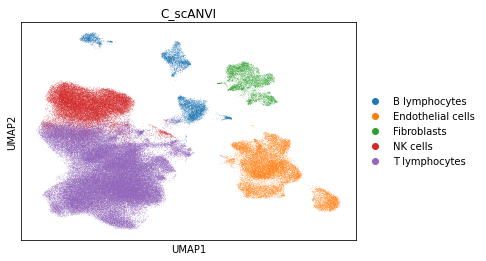

In [161]:
sc.pl.umap(adata_lymphoid, color='C_scANVI')

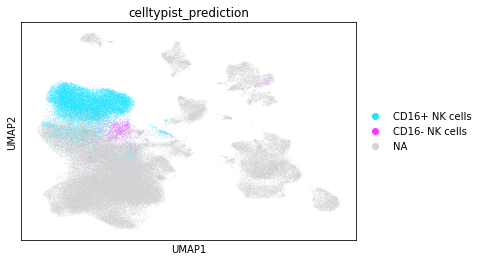

In [20]:
sc.pl.umap(adata_lymphoid, color=['celltypist_prediction'], groups=['CD16+ NK cells', 'CD16- NK cells'], save='cd16_celltypist_prediction.pdf')